In [169]:
import sys
import sympy as sp
import math
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

(-5.0, 5.0)

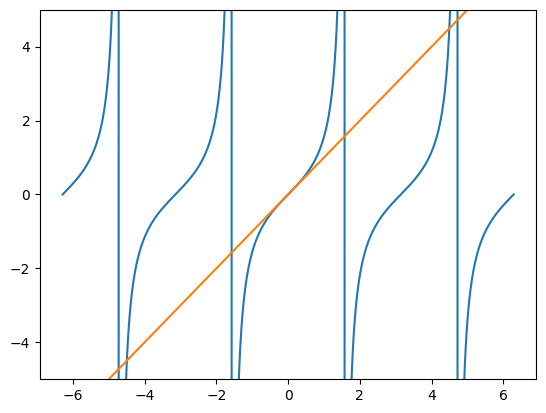

In [170]:
eps = 10e-5;
task = lambda x: sp.tan(x) - x

x = sp.symbols("x")
Ox = np.linspace(-2 * np.pi, 2 * np.pi, 1000)
plt.plot(Ox, np.tan(Ox))
plt.plot(Ox, Ox)
plt.ylim(-5, 5)

In [171]:
def choose_tan_interval(n):
    return [(-np.pi / 2) + (n * np.pi) + eps, (np.pi / 2) + (n * np.pi) - eps]

In [172]:
# Requirements:
#  f(x) is a monotonic and continuous function on the given interval.
#  At the endpoints of the interval, the values of f(x) have opposite signs.


def dichotomy_method(expression, interval, epsilon=eps):
    a = np.float64(interval[0])
    b = np.float64(interval[1])

    if expression(a) * expression(b) >= 0:
        print("Wrong interval!")
        return None

    c = a
    iterations = 0
    while (b - a) / 2 > epsilon:
        c = (a + b) / 2
        iterations += 1
        if expression(c) == 0.0:
            break
        elif expression(c) * expression(b) < 0:
            a = c
        else:
            b = c

    return c, iterations

In [173]:
dichotomy_method(task, choose_tan_interval(1))

(4.493518898735156, 14)

In [309]:
def get_new_interval(expression, old_interval, accuracy):
    step = (old_interval[1] - old_interval[0]) / accuracy
    interval = np.arange(
        old_interval[0],
        old_interval[1],
        step,
    )

    func_interval = [expression(i) for i in interval]
    
    index = min(enumerate(func_interval), key = lambda x: abs(x[1]))[0]
    if func_interval[index + 1] > func_interval[index - 1]:
        first_bound = interval[index - 1]
        second_bound = interval[index]
    else:
        first_bound = interval[index]
        second_bound = interval[index + 1]

    return first_bound, second_bound

In [310]:
# Requirements:
#  The modulus of the first derivative is less than one near zero.
#  Gets f(x) from equation f(x) = x.


def simple_iteration_method(expression, interval, epsilon=eps):
    a = np.float64(interval[0])
    b = np.float64(interval[1])

    df = expression(x).diff(x)

    a, b = get_new_interval(expression, [a, b], 200)

    if (abs(df.evalf(subs={x: a})) >= 1) or (abs(df.evalf(subs={x: b})) >= 1):
        print(df.evalf(subs={x: a}), df.evalf(subs={x: b}))
        print("Wrong interval!")
        return None

    x0 = (a - b) / 2
    xn = x0
    iterations = 0

    while True:
        iterations += 1
        
        x0 = xn
        xn = expression(x0)
        
        if abs(xn - x0) < epsilon:
            break
        

    return xn, iterations

In [311]:
simple_iteration_method(lambda x: sp.tan(x) - x, choose_tan_interval(0))

(-1.40289831888993e-21, 2)

In [306]:
def newton_method(expression, interval, epsilon=eps):
    a = np.float64(interval[0])
    b = np.float64(interval[1])

    df = expression(x).diff(x)

    a, b = get_new_interval(expression, [a, b], 200)

    # if (abs(df.evalf(subs={x: a})) >= 1) or (abs(df.evalf(subs={x: b})) >= 1):
    #     print(df.evalf(subs={x: a}), df.evalf(subs={x: b}))
    #     print("Wrong interval!")
    #     return None

    x0 = a
    xn = x0
    iterations = 0

    while True:
        iterations += 1
        
        x0 = xn
        xn = x0 - expression(x0) / df.evalf(subs={x: x0})
        
        if abs(xn - x0) < epsilon:
            break
        

    return xn, iterations



In [308]:
newton_method(task, choose_tan_interval(0))

TypeError: Invalid NaN comparison